## Importance analysis and first perforance baselines

## Encoding of all features

In this first iteration of design, we chose to simplify the model as much as possible. That includes dropping samples in case of doubt and not performing advanced feature engineering.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
df = pd.read_csv('../data/df_clean.csv')

/var/folders/41/hgg8f6_j1dj4y4mt0w22d8ym0000gn/T/ipykernel_9457/828197386.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/df_clean.csv')


In [37]:
drop_columns = ['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank' ,'BankState', 'ApprovalDate', 'ApprovalFY',
                'CreateJob', 'RetainedJob','NoEmp', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
                'BalanceGross', 'ChgOffPrinGr', 'MIS_Status']
df.drop(drop_columns, inplace=True, axis=1)
df.head(1)

,NAICS,Term,NewExist,FranchiseCode,UrbanRural,RevLineCr,LowDoc,GrAppv,SBA_Appv,Default,NAICS_i,isNewBusiness,isFranchise,SBARatio
0,451120,84,2.0,1,0,0,1,60000.0,48000.0,0,45,1.0,0,0.8


In [38]:
target = 'Default'
features = [feature for feature in df.columns if feature not in target]

In [39]:
df[features].describe()

,NAICS,Term,NewExist,FranchiseCode,UrbanRural,RevLineCr,LowDoc,GrAppv,SBA_Appv,NAICS_i,isNewBusiness,isFranchise,SBARatio
count,870514.000000,870514.000000,870514.000000,870514.000000,870514.000000,870514.000000,870514.000000,8.705140e+05,8.705140e+05,870514.000000,870514.000000,870514.000000,870514.000000
mean,397670.284370,111.508946,1.282303,2794.073226,0.754880,0.229363,0.123910,1.951101e+05,1.514752e+05,39.514401,0.282303,0.058415,0.711526
std,264128.651724,79.177488,0.450120,12847.026352,0.647823,0.420424,0.329479,2.843112e+05,2.288713e+05,26.364679,0.450120,0.234526,0.173216
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+03,5.000000e+02,0.000000,0.000000,0.000000,0.028140
25%,235110.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.500000e+04,2.240000e+04,23.000000,0.000000,0.000000,0.500000
50%,445310.000000,84.000000,1.000000,1.000000,1.000000,0.000000,0.000000,9.400000e+04,6.375000e+04,44.000000,0.000000,0.000000,0.750000
75%,561740.000000,120.000000,2.000000,1.000000,1.000000,0.000000,0.000000,2.300000e+05,1.770000e+05,56.000000,1.000000,0.000000,0.850000
max,928120.000000,569.000000,2.000000,99999.000000,2.000000,1.000000,1.000000,5.000000e+06,4.500000e+06,92.000000,1.000000,1.000000,1.000000


In [40]:
# Function to obtain profit from a loans set, it's predictions and the ground truth.
def get_profit (X: pd.DataFrame, y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
    # Initialize an empty list to store profits for each sample
    profits = []
    
    for index, row in X.iterrows():
        if y_pred[index] == 0 and y_true[index] == 0:
            profit = 0.05 * row['GrAppv']
        elif y_pred[index] == 0 and y_true[index] == 1:
            profit = -0.15 * row['GrAppv']
        else:
            profit = 0  # If conditions don't match, profit is zero
        profits.append(profit)
    
    # Return the accumulated profit for all samples
    return sum(profits)

These are the features used in our first model. As we will use tree-based models, there is no need for normalization. Is important to see that the count is the same in all of them, meaning that we have succesfully got rid of all the nulls and outliers. \
All of them are numerical by now, and some will have to get encoded before our model can be trained.

In [41]:
print(f'Our ratio of target variable is {df[target].mean()} ')
print(f"The baseline performance of a trivial model is {(1-df[target].mean())*100:.2f}%!")

Our ratio of target variable is 0.1714619179013778 
The baseline performance of a trivial model is 82.85%!


This means that a model that always predicted that a loan will not default will result in a performance of almost 83%! If our model performs close to that number it would be considered useless.

In [42]:
# This trivial model always identifies a loan as paid in full. Let's score it.
def trivial_model(X: pd.DataFrame):
    return np.zeros((len(X), 1))

from sklearn.metrics import accuracy_score, f1_score
trivial_acc = accuracy_score(df[target], trivial_model(df[features]))
trivial_f1 = f1_score(df[target], trivial_model(df[features]))
trivial_profit = get_profit(df[features], df[target], trivial_model(df[features]))

print(f"Our trivial model has {trivial_acc*100:.2f}% accuracy!")
print(f"However, it has {trivial_f1*100:.2f}% F1 score. (0 recall and 0 precision)")
print(f"We would obtain a profit of ${trivial_profit:,.2f} accepting every single loan.")


Our trivial model has 82.85% accuracy!
However, it has 0.00% F1 score. (0 recall and 0 precision)
We would obtain a profit of $4,827,435,072.45


Therefore, accuracy won't be used as a metric. We will prefer others like recall, precision or F1!

## Decision trees for importance analysis

### Encoding

In [43]:
df[features].head(1)

,NAICS,Term,NewExist,FranchiseCode,UrbanRural,RevLineCr,LowDoc,GrAppv,SBA_Appv,NAICS_i,isNewBusiness,isFranchise,SBARatio
0,451120,84,2.0,1,0,0,1,60000.0,48000.0,45,1.0,0,0.8


Even though all of our variables seem numerical right now, some of them have to be encoded as they have cathegorical meaning. Specifically, NAICS_i and UrbanRural don't have numerical meaning.

In [44]:
# Encode categorical features. We will use one-hot encoding, as the number of possibilities are manageable.

cat_variables = [
    'NAICS_i',
    'UrbanRural'
]

df_encoded = df[features]

df_encoded = pd.get_dummies(
    data = df_encoded,
    prefix = cat_variables,
    columns = cat_variables
)

df_encoded.head(1)

,NAICS,Term,NewExist,FranchiseCode,RevLineCr,LowDoc,GrAppv,SBA_Appv,isNewBusiness,isFranchise,...,NAICS_i_56,NAICS_i_61,NAICS_i_62,NAICS_i_71,NAICS_i_72,NAICS_i_81,NAICS_i_92,UrbanRural_0,UrbanRural_1,UrbanRural_2
0,451120,84,2.0,1,0,1,60000.0,48000.0,1.0,0,...,False,False,False,False,False,False,False,True,False,False


Using pandas get_dummies, our one-hot encoded features take boolean values instead of integers. It won't matter for tree-based models, but if we were to train a neural network or regression model this would be problematic.\
In that case, we will use scikit-learn's one-hot encoder.

### Splitting

In [45]:
# Let's choose out definitive list of encoded features!
features_encoded = [feature for feature in df_encoded.columns if feature not in target]
print(features_encoded)

['NAICS', 'Term', 'NewExist', 'FranchiseCode', 'RevLineCr', 'LowDoc', 'GrAppv', 'SBA_Appv', 'isNewBusiness', 'isFranchise', 'SBARatio', 'NAICS_i_0', 'NAICS_i_11', 'NAICS_i_21', 'NAICS_i_22', 'NAICS_i_23', 'NAICS_i_31', 'NAICS_i_32', 'NAICS_i_33', 'NAICS_i_42', 'NAICS_i_44', 'NAICS_i_45', 'NAICS_i_48', 'NAICS_i_49', 'NAICS_i_51', 'NAICS_i_52', 'NAICS_i_53', 'NAICS_i_54', 'NAICS_i_55', 'NAICS_i_56', 'NAICS_i_61', 'NAICS_i_62', 'NAICS_i_71', 'NAICS_i_72', 'NAICS_i_81', 'NAICS_i_92', 'UrbanRural_0', 'UrbanRural_1', 'UrbanRural_2']


In [46]:
from sklearn.model_selection import train_test_split

In [47]:
# 75% will be for training. 12.5% for cross-validation and hyperparameter tuning and 12.5% for model evaluation.
X_train, X_, y_train, y_ = train_test_split(df_encoded[features_encoded], df[target], train_size=.75)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, train_size=.5)

print(f"X -- Train shape: {X_train.shape}, CV: {X_cv.shape}, test: {X_test.shape}")
print(f"y -- Train shape: {y_train.shape}, CV: {y_cv.shape}, test: {y_test.shape}")

X -- Train shape: (652885, 39), CV: (108814, 39), test: (108815, 39)
y -- Train shape: (652885,), CV: (108814,), test: (108815,)


### Single decision tree
For explainability purposes, and to be able to extract feature importances, we will start by training a single decision tree. Keep in mind that the objective of this model is to offer some insight on which features are having a bigger impact in our model, and not to make real predictions.\
Therefore, we will tune hyperparameters by hand, and plot the training and cross-validation evaluations for each hyperparameter.\
In this way, we will obtain:
1. A representation of which hyperparameters are more promissing for our later models.
2. Information regarding the weight of features in our target distribution.
3. A way to promtly detect high bias or high variance in our model.

In [48]:
# Choose hyperparameters to be tried. We will tune by hand the minimum number of samples in a leaf to do another split and the maximum depth
# to which the tree can reach.

min_samples_list = [20, 50, 100, 200, 500, 1000, 10000]
max_depths_list = [4, 8, 12, 16, 20, 32, 64, None]

Optimum minimum samples to split is 200. CV Recall: 0.8045946091354172


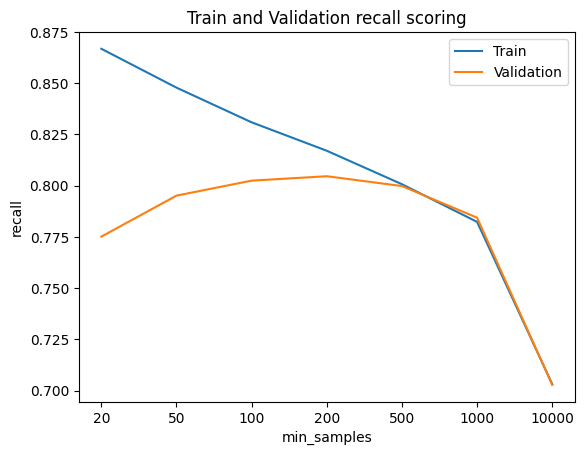

In [49]:
# Recall score will be used as a metric, as the cost of false negatives (defaulted loans which we fail to detect) is
# higher than that of false positives (paid in full loans we flag as default). 

from sklearn.tree import DecisionTreeClassifier # Single tree
from sklearn.metrics import recall_score

# Recall array for latter plotting.
recalls = {
    "train": [],
    "cv": []
}

# Iterate over the min samples list.
for min_sample in min_samples_list:

    # Train a model for each one.
    model = DecisionTreeClassifier(min_samples_split=min_sample).fit(X_train, y_train)

    # Predictions on train and cross-validation sets.
    yhat_train = model.predict(X_train)
    yhat_cv = model.predict(X_cv)
    
    # Append the score to the recalls array.
    recalls["train"].append(recall_score(y_train, yhat_train))
    recalls["cv"].append(recall_score(y_cv, yhat_cv))

optimum_min_samples = min_samples_list[np.argmax(recalls['cv'])]
print(f"Optimum minimum samples to split is {optimum_min_samples}. CV Recall: {np.max(recalls['cv'])}")

plt.title('Train and Validation recall scoring')
plt.xlabel('min_samples')
plt.ylabel('recall')
plt.xticks(ticks = range(len(min_samples_list )),labels=min_samples_list)
plt.plot(recalls["train"])
plt.plot(recalls["cv"])
plt.legend(['Train','Validation'])

It is possible to see how a smaller minimum of samples to split gets good train recall toguether with bad validation recall. That's overfitting, or high variance! In our optimum, we get a better variance, with both train and cv performing similarly good. That means that our model generalizes quite well to new data.

Optimum maximum depth to stop is 12. CV Recall: 0.7928121805563028


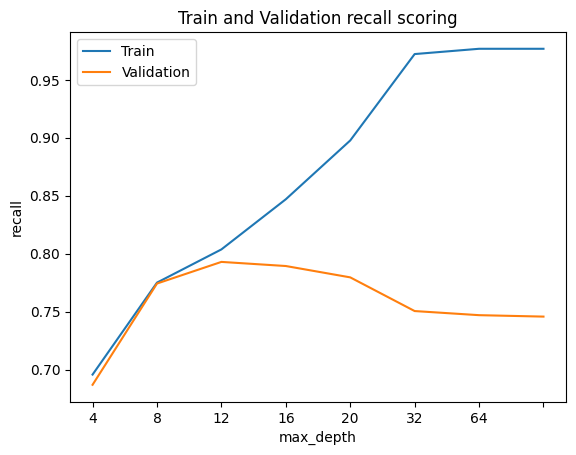

In [50]:
# Recall array for latter plotting.
recalls = {
    "train": [],
    "cv": []
}

# Iterate over the max depths list.
for max_depth in max_depths_list:
    
    model = DecisionTreeClassifier(max_depth = max_depth).fit(X_train, y_train)

    yhat_train = model.predict(X_train)
    yhat_cv = model.predict(X_cv)

    recalls["train"].append(recall_score(y_train, yhat_train))
    recalls["cv"].append(recall_score(y_cv, yhat_cv))

optimimum_max_depth = max_depths_list[np.argmax(recalls['cv'])]

print(f"Optimum maximum depth to stop is {optimimum_max_depth}. CV Recall: {np.max(recalls['cv'])}")

plt.title('Train and Validation recall scoring')
plt.xlabel('max_depth')
plt.ylabel('recall')
plt.xticks(ticks = range(len(max_depths_list)),labels=max_depths_list)
plt.plot(recalls["train"])
plt.plot(recalls["cv"])
plt.legend(['Train','Validation'])


Similarly, if the depth of the tree is very big or unlimited, the model overfits. In our optimal, the model performs good with unseen data.

In [51]:
# Now let's pick both of these together and train a model!
dtmodel = DecisionTreeClassifier(
    min_samples_split=optimum_min_samples,
    max_depth=optimimum_max_depth).fit(X_train, y_train)

### Feature importance

<class 'numpy.ndarray'>


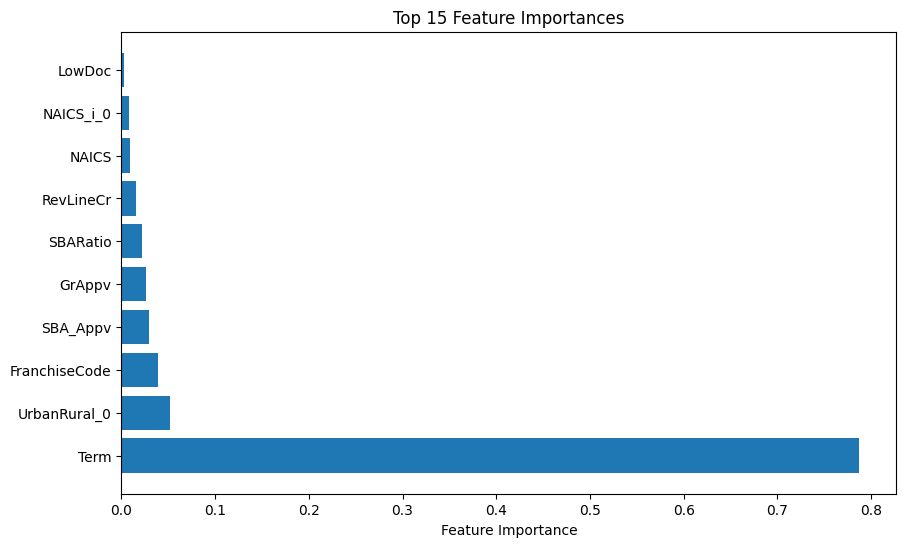

In [52]:
# Get feature importances from the trained model
importances = dtmodel.feature_importances_

# Get indices of top 15 importances
top_indices = np.argsort(importances)[::-1][:10]
print(type(top_indices))
top_importances = importances[top_indices]
top_feature_names = np.array(features_encoded)[top_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_importances)), top_importances, align='center')
plt.yticks(range(len(top_importances)), top_feature_names)
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances')
plt.show()

Here we can see that our model is mainly taking into account the term of the loan. As we discovered during exploration, shorter term loans are way more likely to default.

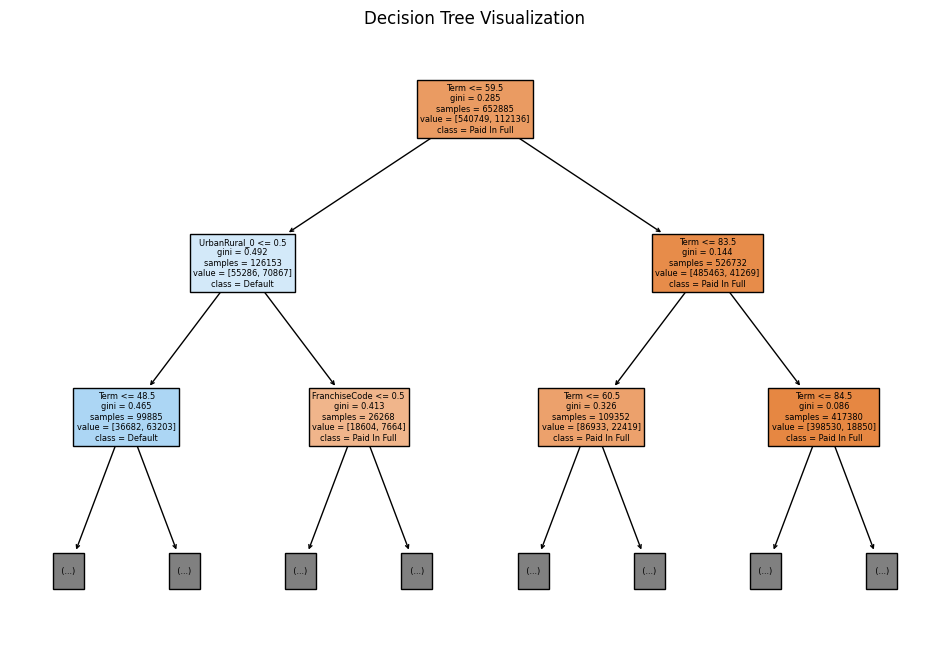

In [53]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 8))
plot_tree(dtmodel, filled=True, feature_names=features_encoded, class_names=['Paid In Full', 'Default'], max_depth=2)
plt.title("Decision Tree Visualization")
plt.show()

## Scoring of the single tree. Confusion matrixes.
To get a valuable score of our first tree, we will score it against totally unseen data, our X_test set. It has never been used yet, not even for picking hyperparameters. In this way we can see how our model would perform with totally new samples.

In [54]:
yhat_test = dtmodel.predict(X_test)

In [55]:
test_recall = recall_score(y_test, yhat_test)
print(f"Our model has a test recall of {test_recall*100:.2f}%!")

Our model has a test recall of 78.52%!


That's great! It is in line with both train and cross-validation recalls, meaning that our model is not overfitting. Now let's draw the test confusion matrix.

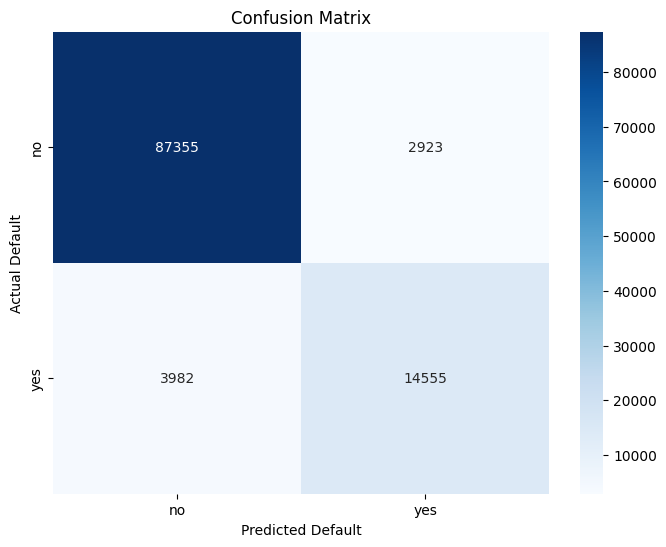

In [57]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test, yhat_test)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.xlabel('Predicted Default')
plt.ylabel('Actual Default')
plt.title('Confusion Matrix')
plt.show()


That is actually quite good! We are spotting most of the defaults. However, we can perform even better in latter models.\
 And for our whole data:

Overall recall 0.792369020501139
Obtained profit: $6,273,199,093.05


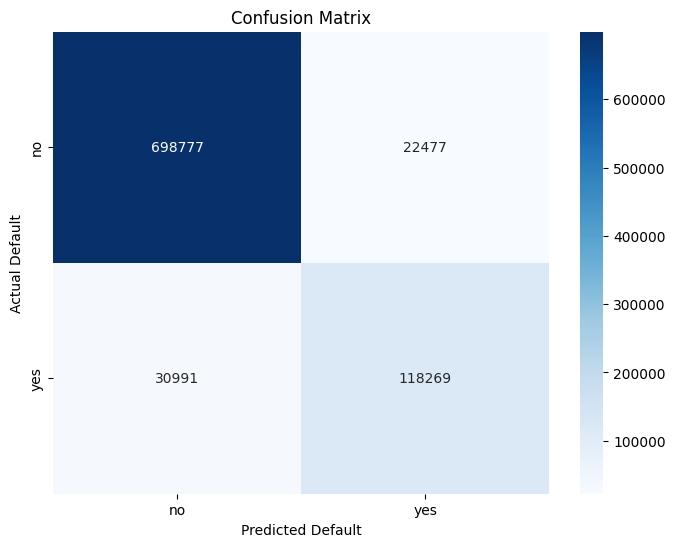

In [58]:
# Calculate the confusion matrix
yhat_total = dtmodel.predict(df_encoded[features_encoded])
cm = confusion_matrix(df[target], yhat_total)

print(f"Overall recall {recall_score(df[target], yhat_total)}")
print(f"Obtained profit: ${get_profit(df[features], df[target], yhat_total):,.2f}")
# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.xlabel('Predicted Default')
plt.ylabel('Actual Default')
plt.title('Confusion Matrix')
plt.show()

This is the confusion matrix of our first simple model in all the filtered data, a single decision tree. From now onwards, taking this as a baseline performance we will be more agressive in the hyperparameter optimization.\
We will also try other encodings of features, and feature engineer new ones to be as good as we can.

In [23]:
# Obtain a dataframe that includes the features and the target
# Indexes need to be reseted so that the concatenation makes sense.
df_encoded_reset = df_encoded[features_encoded].reset_index(drop=True)
df_target_reset = df[target].reset_index(drop=True)

# Concatenating along columns axis
df_out = pd.concat([df_encoded_reset, df_target_reset], axis=1)

In [24]:
df_out.to_csv('../data/df_encoded.csv', index=False)

In [25]:
pd.DataFrame(yhat_total).to_csv('../data/baseline_predict.csv', index=False)